<a href="https://colab.research.google.com/github/cccaaannn/deep_learning_colab/blob/master/keras/lstm/lstm_stock_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**check the gpu**

In [ ]:
!nvidia-smi

imports

In [ ]:
# keras
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# sklearn
from sklearn.preprocessing import MinMaxScaler

# other libs
import pandas_datareader as web
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

plt.style.use('fivethirtyeight')

load the data

In [12]:
df2 = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17') 

In [183]:
df = pd.read_csv("/content/10y.csv", index_col=0)
# df = df[::-1]

In [129]:
df = df.tail(240)

In [ ]:
print(df.shape) 
df.tail()

set options

In [380]:
plot_title = "Prices"
df_col_to_use = "Kapanış(TL)"
model_path = "/content/drive/My Drive/models/model.h5"

test_split = 0.05
lstm_step = 60
batch_size = 1
nr_epochs = 3

plot data

In [ ]:
plt.figure(figsize=(16,8))
plt.title(plot_title)
plt.plot(df[df_col_to_use])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.show()

helper functions

In [16]:
def create_training_data_lstm(data, lstm_step = 60):
    # train data processing
    x, y = [], []

    # create_sequence
    for i in range(lstm_step, len(data)):
        x.append(data[i-lstm_step:i,0])
        y.append(data[i,0])
    
    # conver to numpy array
    x = np.array(x)
    y =np.array(y)

    #Reshape the data into the shape accepted by the LSTM
    x = np.reshape(x, (x.shape[0], lstm_step, 1))

    return x, y

In [17]:
def rmse(predictions, actual):
    return np.sqrt(np.mean(((predictions- actual)**2)))

In [73]:
def mse_percentage(predictions, actual): 
    rmse_error = np.mean(((predictions - actual)**2))
    pred_len = len(predictions)
    rmse_percent_error = ((100 * rmse_error) / pred_len)
    return rmse_percent_error

crate training and testing data for lstm

In [ ]:
data = df.filter([df_col_to_use])
dataset = data.values

scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

train_size = math.ceil(len(scaled_data) * (1-test_split))
test_size = len(scaled_data) - train_size
train_data = scaled_data[0 : train_size, :]
# test_data = scaled_data[train_size : len(scaled_data), :]
test_data = scaled_data[train_size - lstm_step: , : ]

x_train, y_train = create_training_data_lstm(train_data, lstm_step = lstm_step)
x_test, y_test = create_training_data_lstm(test_data, lstm_step = lstm_step)

print(len(x_train), len(x_test))

build lstm model

In [383]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [237]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1], 1)))
# model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=25))
# model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')

train

In [ ]:
model.fit(x_train, y_train, batch_size = batch_size, epochs = nr_epochs)

testing 

In [385]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # Undo scaling

rmse

In [ ]:
print("rmse", rmse(predictions, y_test))
# print("mse %", mse_percentage(predictions, y_test))

create validation table

In [ ]:
data = df.filter([df_col_to_use])
train = data[:train_size]
valid = data[train_size:]
valid['Predictions'] = predictions

In [ ]:
valid.tail(15)

plot predicitons for validation

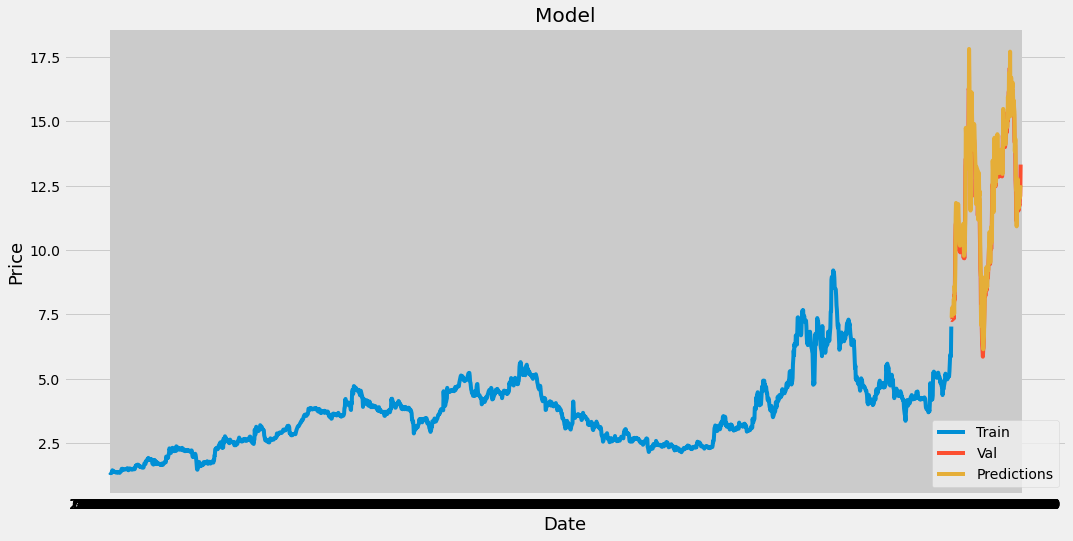

In [389]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.plot(train[df_col_to_use])
plt.plot(valid[[df_col_to_use, 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

save model

In [19]:
model.save(model_path)

predict single day

connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

load model

In [7]:
model = keras.models.load_model(model_path)

make prediciton

In [ ]:
new_df = df.filter([df_col_to_use])
dataset = new_df.values

# last_days = new_df[-61:-1].values # bugun
last_days = new_df[-lstm_step:].values # yarın

scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

last_days_scaled = scaler.transform(last_days)

X_test = []
X_test.append(last_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)

pred_price = scaler.inverse_transform(pred_price)

print(pred_price)